# skxplore
## A top layer package for scikit-learn

This scikit-learn top layer package finds the machine learning model and hyperparameters best-suited for the dataset and properties the user has set.

The find_model function has the following parameters:<br>
`dataset` takes a pandas dataframe as its value<br>
`train_size` is a float from the interval (0, 1); it defines the partition of the dataset for training and testing<br>
`problem` has three selections: classification, regression, and clustering<br>
`label` takes a column name in the pandas dataframe and treats it as the label for classification or the target value for regression<br>
`datatype` has two types: numerical and nominal (for text classification); numerical by default<br>
`dim_reduction` takes True or False as its value; it gives the option to apply dimensionality reduction on the dataset; False by default<br>
`features` is the number of components to remain after dimensionality reduction; auto by default<br>
`contains_negative` takes True or False as its value; setting its value to True uses principal component analysis, while setting its value to False uses non-negative matrix factorization; True by default<br>
`ensembling` takes True or False as its value; setting its value to True makes use of ensemble methods from base estimators, while setting its value to False disables ensembling<br>
`priority` has two selections: accuracy and time; selecting accuracy would enable the module to find for better hyperparameters and optimize the different algorithms in consideration; selecting time would use the default hyperparameters<br>

skxplore considers the following algorithms:<br>
1. Classification<br>
&nbsp;&nbsp;&nbsp;&nbsp;`Naive Bayes algorithm`, `K-nearest neighbors algorithm`, `Support vector machine classifier`, `eXtreme gradient boosting classifier`, and `Light gradient boosting machine classifier`
2. Regression<br>
&nbsp;&nbsp;&nbsp;&nbsp;`Lasso regression`, `Ridge regression`, `Elastic net regression`, `Linear regression`, `Support vector machine regressor`, `eXtreme gradient boosting regressor`, and `Light gradient boosting machine regressor`
3. Clustering<br>
&nbsp;&nbsp;&nbsp;&nbsp;`K-means clustering`, `Spectral clustering`, `Gaussian mixture model`, `Density-based spatial clustering of applications with noise (DBSCAN) algorithm`, and `Ordering points to identify the clustering structure (OPTICS) algorithm`

In [1]:
# Importing the preprocessing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Importing the classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Importing the regressors
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Importing the clustering algorithms
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, explained_variance_score, silhouette_score
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

In [2]:
def find_model(dataset, train_size, problem, label="", datatype="numerical",
               dim_reduction=False, components="auto", contains_negative=True, ensembling=True, priority="accuracy"):
    if datatype == "numerical" and problem == "classification":
        # Label encode data to ensure everything is numeric
        print("Label encoding. . .")
        dataset = dataset.apply(LabelEncoder().fit_transform)
    
    # Splitting the dataset into the features and label
    print("Identifying feature columns and label column. . .")
    X = dataset[dataset.columns.difference([label])] #features
    y = dataset[label] #label
    
    if datatype == "nominal" and problem == "classification":
        if dim_reduction:
            print("Dimensionality reduction is not supported if your datatype is nominal.")
            exit()
        else:
            print("Applying term frequency inverse document frequency on text. . .")
            Tfidf_vect = TfidfVectorizer(max_features=2500)
            Tfidf_vect.fit_transform(X)
            print("Label encoding. . .")
            y = y.apply(LabelEncoder().fit_transform)
    
    # Reduce dimensionality of dataset
    if dim_reduction:
        print("Performing dimensionality reduction. . .")
        print("Features' shape before reduction is", X.shape)
        if contains_negative: # If dataset contains negative values, use principal component analysis
            if components == "auto":
                print("Using default number of components for principal component analysis. . .")
                pca = PCA(n_components=2)
            else:
                print("Using", components, "components for principal component analysis. . .")
                pca = PCA(n_components=components)
            X = pca.fit_transform(X)
        else: # Otherwise, use non-negative matrix factorization
            if components == "auto":
                print("Using default number of components for non-negative matrix factorization. . .")
                nmf = NMF(n_components=2)
            else:
                print("Using", components, "components for principal component analysis. . .")
                nmf = NMF(n_components=components)
            X = nmf.fit_transform(X)
        print("Features' shape after reduction is", X.shape)
    
    # Split X and y into training and testing datasets
    print("Splitting datasets for training and testing. . .")
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size)
    
    # Scale variables to standardize values
    print("Standardizing values. . .")
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    if priority == "accuracy":
        if problem == "classification":
            find_classification_model(X_train, X_test, y_train, y_test, priority="accuracy", ensembling=ensembling, datatype=datatype)
        elif problem == "regression":
            find_regression_model(X_train, X_test, y_train, y_test, ensembling=ensembling)
        elif problem == "clustering":
            find_clustering_model(X, y)
        
    if priority == "time":
        if problem == "classification":
            find_classification_model(X_train, X_test, y_train, y_test, priority="time", ensembling=ensembling, datatype=datatype)
        elif problem == "regression":
            find_regression_model(X_train, X_test, y_train, y_test, ensembling=ensembling)
        elif problem == "clustering":
            find_clustering_model(X, y)

In [3]:
def find_classification_model(X_train, X_test, y_train, y_test, priority="accuracy", ensembling=True, datatype="numerical"):
    models = []
    overall_accuracies = []
    
    if ensembling:
        print("Ensembing is enabled.")
        # Use XGBoost
        if priority == "accuracy":
            learning_rate_list = [0.1, 0.01, 0.001]
            gamma_list = [0, 1, 5]
            colsample_bytree_list = [0.3, 0.5, 0.8, 1]
            # Creating list of cv scores
            scores = []
            params = []
            
            for lr in learning_rate_list:
                for g in gamma_list:
                    for cb in colsample_bytree_list:
                        xgb = XGBClassifier(learning_rate=lr, gamma=g, colsample_bytree=cb)
                        xgb.fit(X_train, y_train)
                        y_pred = xgb.predict(X_test)
                        scores.append(accuracy_score(y_test, y_pred))
                        params.append([lr, g, cb])
            XGB_max_scores = max(scores)
            print("XGBoost classifier score is:", XGB_max_scores, "with the following values\nfor learning rate, g, and number of columns used by each tree:", params[scores.index(XGB_max_scores)])
            lr_best = params[scores.index(XGB_max_scores)][0] 
            g_best = params[scores.index(XGB_max_scores)][1]
            cb_best = params[scores.index(XGB_max_scores)][2]
            models.append(XGBClassifier(learning_rate=lr_best, gamma=g_best, colsample_bytree=cb_best))
            overall_accuracies.append(XGB_max_scores)
            
        if priority == "time":
            xgb = XGBClassifier()
            xgb.fit(X_train, y_train)
            y_pred = xgb.predict(X_test)
            print("XGBoost classifier score is:", accuracy_score(y_test, y_pred), "using\n", xgb)
            models.append(XGBClassifier())
            overall_accuracies.append(accuracy_score(y_test, y_pred))
            
            # Use LightGBM
            learning_rate_list = [0.1, 0.01, 0.001]
            objective_list = ["binary", "multiclass"]
            colsample_bytree_list = [0.3, 0.5, 0.8, 1]
            # Creating list of cv scores
            scores = []
            params = []
            
            for lr in learning_rate_list:
                for o in objective_list:
                    for cb in colsample_bytree_list:
                        lgbm = LGBMClassifier(learning_rate=lr, objective=o, colsample_bytree=cb)
                        lgbm.fit(X_train, y_train)
                        y_pred = lgbm.predict(X_test)
                        scores.append(accuracy_score(y_test, y_pred))
                        params.append([lr, o, cb])
            LGBM_max_scores = max(scores)
            print("LightGBM classifier score is:", LGBM_max_scores, "with the following values\nfor learning rate and objective:", params[scores.index(LGBM_max_scores)])
            lr_best = params[scores.index(LGBM_max_scores)][0] 
            o_best = params[scores.index(LGBM_max_scores)][1]
            cb_best = params[scores.index(LGBM_max_scores)][2]
            models.append(LGBMClassifier(learning_rate=lr_best, objective=o_best, colsample_bytree=cb_best))
            overall_accuracies.append(LGBM_max_scores)
            
    else:
        print("Ensembling is disabled.")
        
    if priority == "accuracy": # If the priority is to have the highest accuracy possible
        if datatype == "numerical": # If the data is numeric, use support vector machine or k-nearest neighbors
            # Use SVM
            # Creating lists of gamma and c for SVM
            gamma_list = [1e-3, 1e-5, 1e-7, 1e-9]
            c_list = [1, 10, 100, 1000]
            kernel_list = ["linear", "rbf", "poly"]
            # Creating list of cv scores
            scores = []
            params = []

            # Perform gridsearch on SVC model
            for c in c_list:
                for g in gamma_list:
                    for k in kernel_list:
                        if ensembling:
                            svc = AdaBoostClassifier(SVC(probability=True, gamma=g, C=c, kernel=k), n_estimators=15)
                        else:
                            svc = SVC(gamma=g, C=c, kernel=k)
                        svc.fit(X_train, y_train)
                        y_pred = svc.predict(X_test)
                        scores.append(accuracy_score(y_test, y_pred))
                        params.append([g, c, k])
            SVC_max_scores = max(scores)
            print("Support vector classifier score is:", SVC_max_scores, "with the following values\nfor g, c, and k:", params[scores.index(SVC_max_scores)])
            g_best = params[scores.index(SVC_max_scores)][0]
            c_best = params[scores.index(SVC_max_scores)][1]
            k_best = params[scores.index(SVC_max_scores)][2]
            if ensembling:
                models.append(AdaBoostClassifier(SVC(probability=True, gamma=g_best, C=c_best, kernel=k_best), n_estimators=15))
            else:
                models.append(SVC(gamma=g_best, C=c_best, kernel=k_best))
            overall_accuracies.append(SVC_max_scores)
            
            # Use KNN
            # Creating list of neighbors for KNN
            neighbor_list = [2, 3, 5, 10, 15, 20]
            # Creating list of cv scores
            scores = []
            params = []
            
            # Perform gridsearch on KNN model
            for n in neighbor_list:
                if len(X_train[0]) <= n:
                    if ensembling:
                        knn = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=n), n_estimators=100)
                    else:
                        knn = KNeighborsClassifier(n_neighbors=n)
                    knn.fit(X_train, y_train)
                    y_pred = knn.predict(X_test)
                    scores.append(accuracy_score(y_test, y_pred))
                    params.append(n)
            KNN_max_scores = max(scores)
            print("K-nearest neighbor classifier score is:", KNN_max_scores, "with the k value =", params[scores.index(KNN_max_scores)])
            k_best = params[scores.index(KNN_max_scores)]
            if ensembling:
                models.append(BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=k_best), n_estimators=100))
            else:
                models.append(KNeighborsClassifier(n_neighbors=k_best))
            overall_accuracies.append(KNN_max_scores)
            
        elif datatype == "nominal": # If the data is text, use naive Bayes
            if ensembling:
                nbc = AdaBoostClassifier(GaussianNB(), n_estimators=100)
            else:
                nbc = GaussianNB()
            nbc.fit(X_train, y_train)
            y_pred = nbc.predict(X_test)
            NB_max_score = accuracy_score(y_test, y_pred)
            print("Naive Bayes classifier score is:", NB_max_score, "using\n", nbc)
            if ensembling:
                models.append(AdaBoostClassifier(GaussianNB(), n_estimators=100))
            else:
                models.append(GaussianNB())
            overall_accuracies.append(NB_max_score)

    else: # If the priority is to have a trained classifier model quickly
        if datatype == "numerical": # If the data is numeric, use support vector machine or k-nearest neighbors
            # Use SVM
            if ensembling:
                svc = AdaBoostClassifier(SVC(probability=True), n_estimators=15)
            else:
                svc = SVC()
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            print("Support vector classifier score is:", accuracy_score(y_test, y_pred), "using\n", svc)
            if ensembling:
                models.append(AdaBoostClassifier(SVC(probability=True), n_estimators=15))
            else:
                models.append(SVC())
            overall_accuracies.append(accuracy_score(y_test, y_pred))
            
            # Use KNN
            if ensembling:
                knn = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=100)
            else:
                knn = KNeighborsClassifier()
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            print("K-nearest neighbor classifier score is:", accuracy_score(y_test, y_pred), "using\n", knn)
            if ensembling:
                models.append(BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=100))
            else:
                models.append(KNeighborsClassifier())
            overall_accuracies.append(accuracy_score(y_test, y_pred))
        
        elif datatype == "nominal": # If the data is text, use naive Bayes
            if ensembling:
                nbc = AdaBoostClassifier(GaussianNB(), n_estimators=100)
            else:
                nbc = GaussianNB()
            nbc.fit(X_train, y_train)
            y_pred = nbc.predict(X_test)
            NB_max_score = accuracy_score(y_test, y_pred)
            print("Naive Bayes classifier score is:", NB_max_score, "using\n", nbc)
            if ensembling:
                models.append(AdaBoostClassifier(GaussianNB(), n_estimators=100))
            else:
                models.append(GaussianNB())
            overall_accuracies.append(NB_max_score)
            
    top_accuracy = max(overall_accuracies)
    best_model = models[overall_accuracies.index(top_accuracy)]
    print("\nWith consideration of", priority, "as the priority, the best model found for classifying the dataset is:\n", best_model)

In [4]:
@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=FutureWarning)
def find_regression_model(X_train, X_test, y_train, y_test, ensembling=True):
    models = []
    overall_accuracies = []
    
    if ensembling:
        print("Ensembling is enabled.")
        learning_rate_list = [0.1, 0.01, 0.001]
        gamma_list = [0, 1, 5]
        colsample_bytree_list = [0.3, 0.5, 0.8, 1]
        # Creating list of cv scores
        scores = []
        params = []

        for lr in learning_rate_list:
            for g in gamma_list:
                for cb in colsample_bytree_list:
                    xgb = XGBRegressor(learning_rate=lr, gamma=g, colsample_bytree=cb, objective="reg:squarederror")
                    xgb.fit(X_train, y_train)
                    y_pred = xgb.predict(X_test)
                    scores.append(explained_variance_score(y_test, y_pred))
                    params.append([lr, g, cb])
        XGB_max_scores = max(scores)
        print("XGBoost regressor explained variance score is:", XGB_max_scores, "with the following values\nfor learning rate, g, and number of columns used by each tree:", params[scores.index(XGB_max_scores)])
        lr_best = params[scores.index(XGB_max_scores)][0] 
        g_best = params[scores.index(XGB_max_scores)][1]
        cb_best = params[scores.index(XGB_max_scores)][2]
        models.append(XGBRegressor(learning_rate=lr_best, gamma=g_best, colsample_bytree=cb_best, objective="reg:squarederror"))
        overall_accuracies.append(XGB_max_scores)
        
        # Use LightGBM
        learning_rate_list = [0.1, 0.01, 0.001]
        colsample_bytree_list = [0.3, 0.5, 0.8, 1]
        # Creating list of cv scores
        scores = []
        params = []

        for lr in learning_rate_list:
            for cb in colsample_bytree_list:
                lgbm = LGBMRegressor(learning_rate=lr, colsample_bytree=cb)
                lgbm.fit(X_train, y_train)
                y_pred = lgbm.predict(X_test)
                scores.append(explained_variance_score(y_test, y_pred))
                params.append([lr, cb])
        LGBM_max_scores = max(scores)
        print("LightGBM regressor explained variance score is:", LGBM_max_scores, "with the following values\nfor learning rate and objective:", params[scores.index(LGBM_max_scores)])
        lr_best = params[scores.index(LGBM_max_scores)][0] 
        cb_best = params[scores.index(LGBM_max_scores)][1]
        models.append(LGBMRegressor(learning_rate=lr_best, colsample_bytree=cb_best))
        overall_accuracies.append(LGBM_max_scores)
        
    else:
        print("Ensembling is disabled.")
        alpha_list = [100, 50, 25, 10, 5, 1, 0.75, 0.5, 0.25, 0.1, 1e-5]
        max_iter_list = [100000, 50000, 10000, 5000, 10000]
        
        # Use lasso regression
        scores = []
        params = []
        
        for a in alpha_list:
            for i in max_iter_list:
                lasso = Lasso(alpha=a, max_iter=i)
                lasso.fit(X_train, y_train)
                y_pred = lasso.predict(X_test)
                scores.append(explained_variance_score(y_test, y_pred))
                params.append([a, i])
        lasso_max_scores = max(scores)
        print("Lasso model explained variance score is:", lasso_max_scores, "with the values for alpha and max iterations: ", params[scores.index(lasso_max_scores)])
        a_best = params[scores.index(lasso_max_scores)][0]
        i_best = params[scores.index(lasso_max_scores)][1]
        models.append(Lasso(alpha=a_best, max_iter=i_best))
        overall_accuracies.append(lasso_max_scores)
        
        # Use ridge regression
        scores = []
        params = []

        for a in alpha_list:
            for i in max_iter_list:
                ridge = Ridge(alpha=a, max_iter=i)
                ridge.fit(X_train, y_train)
                y_pred = ridge.predict(X_test)
                scores.append(explained_variance_score(y_test, y_pred))
                params.append([a, i])
        ridge_max_scores = max(scores)
        print("Ridge model explained variance score is:", ridge_max_scores, "with the values for alpha and max iterations: ", params[scores.index(ridge_max_scores)])
        a_best = params[scores.index(ridge_max_scores)][0]
        i_best = params[scores.index(ridge_max_scores)][1]
        models.append(Ridge(alpha=a_best, max_iter=i_best))
        overall_accuracies.append(ridge_max_scores)
        
        # Use elastic net
        for a in alpha_list:
            for i in max_iter_list:
                try:
                    elastic = ElasticNet(alpha=a, max_iter=i, l1_ratio=0.5)
                    elastic.fit(X_train, y_train)
                    y_pred = elastic.predict(X_test)
                    scores.append(explained_variance_score(y_test, y_pred))
                    params.append([a, i])
                except:
                    continue
        elastic_max_scores = max(scores)
        a_best = params[scores.index(elastic_max_scores)][0]
        i_best = params[scores.index(elastic_max_scores)][1]
        l1_best = 0.5
        models.append(ElasticNet(alpha=a_best, max_iter=i_best, l1_ratio=0.5))
        overall_accuracies.append(elastic_max_scores)
        print("Elastic net regression explained variance score is:", elastic_max_scores, "with the values\nfor alpha, max iterations, and l1 ratio: ", params[scores.index(elastic_max_scores)])
        
        # Use linear regression
        linear = LinearRegression()
        linear.fit(X_train, y_train)
        y_pred = linear.predict(X_test)
        print("Linear regression explained variance score is:", explained_variance_score(y_test, y_pred), "using\n", linear)
        models.append(LinearRegression())
        overall_accuracies.append(explained_variance_score(y_test, y_pred))
        
        # Use SVM
        # Creating lists of gamma and c for SVM
        gamma_list = [1e-3, 1e-5, 1e-7, 1e-9]
        c_list = [1, 10, 100, 1000]
        kernel_list = ["linear", "rbf", "poly"]
        # Creating list of cv scores
        scores = []
        params = []

        # Perform gridsearch on SVR model
        for c in c_list:
            for g in gamma_list:
                for k in kernel_list:
                    svr = SVR(gamma=g, C=c, kernel=k)
                    svr.fit(X_train, y_train)
                    y_pred = svr.predict(X_test)
                    scores.append(explained_variance_score(y_test, y_pred))
                    params.append([g, c, k])
        SVR_max_scores = max(scores)
        print("Support vector regressor explained variance score is:", SVR_max_scores, "with the following values\nfor g, c, and k:", params[scores.index(SVR_max_scores)])
        g_best = params[scores.index(SVR_max_scores)][0]
        c_best = params[scores.index(SVR_max_scores)][1]
        k_best = params[scores.index(SVR_max_scores)][2]
        models.append(SVR(gamma=g_best, C=c_best, kernel=k_best))
        overall_accuracies.append(SVR_max_scores)
        
    top_accuracy = max(overall_accuracies)
    best_model = models[overall_accuracies.index(top_accuracy)]
    print("\nThe best model found for the regression problem on the dataset is:\n", best_model)

In [5]:
def find_clustering_model(X, y):
    models = []
    overall_accuracies = []
    overall_labels = []
    
    # Use k-means
    scores = []
    labels = []
    n_list = list(range(2, 10))
    for n in n_list:
        kmeans_model = KMeans(n_clusters=n, random_state=1).fit(X)
        labels.append(kmeans_model.labels_)
        scores.append(silhouette_score(X, kmeans_model.labels_, metric='euclidean'))
    kmeans_max_score = max(scores)
    print("K-means clustering found an optimal number of ", n_list[scores.index(kmeans_max_score)], "clusters with a silhouette score of", kmeans_max_score)
    models.append(KMeans(n_clusters=n_list[scores.index(kmeans_max_score)], random_state=1))
    overall_accuracies.append(kmeans_max_score)
    overall_labels.append(labels[scores.index(kmeans_max_score)])
    
    scores = []
    labels = []
    # Use spectral clustering
    for n in n_list:
        sc_model = SpectralClustering(n_clusters=n, random_state=1).fit(X)
        labels.append(sc_model.labels_)
        scores.append(silhouette_score(X, sc_model.labels_, metric='euclidean'))
    sc_max_score = max(scores)
    print("Spectral clustering found an optimal number of ", n_list[scores.index(sc_max_score)], "clusters with a silhouette score of", sc_max_score)
    models.append(SpectralClustering(n_clusters=n_list[scores.index(sc_max_score)], random_state=1))
    overall_accuracies.append(sc_max_score)
    overall_labels.append(labels[scores.index(sc_max_score)])
    
    # Use Gaussian mixture model
    scores = []
    labels = []
    clusters = []
    comp_list = list(range(2, 10))
    for comp in comp_list:
        gmm = GaussianMixture(n_components=comp).fit(X)
        predictions = gmm.predict(X)
        labels.append(predictions)
        clusters.append(len(set(predictions)))
        try:
            scores.append(silhouette_score(X, predictions, metric='euclidean'))
        except:
            continue
    gmm_max_score = max(scores)
    print("Gaussian mixture model found an optimal number of", clusters[scores.index(gmm_max_score)], "clusters with a silhouette score of", gmm_max_score)
    models.append(GaussianMixture(n_components=comp_list[scores.index(gmm_max_score)]))
    overall_accuracies.append(gmm_max_score)
    overall_labels.append(labels[scores.index(gmm_max_score)])
    
    scores = []
    labels = []
    clusters = []
    eps_list = [0.1, 0.5, 1, 2, 5, 10, 25, 50, 100]
    # Use DBSCAN
    for eps in eps_list:
        db_model = DBSCAN(eps=eps).fit(X)
        labels.append(db_model.labels_)
        clusters.append(len(set(db_model.labels_)))
        try:
            scores.append(silhouette_score(X, db_model.labels_, metric='euclidean'))
        except:
            continue
    db_max_score = max(scores)
    print("Density-based spatial clustering of applications with noise (DBSCAN) algorithm\nfound an optimal number of", clusters[scores.index(db_max_score)], "clusters with a silhouette score of", db_max_score)
    models.append(DBSCAN(eps=eps_list[scores.index(db_max_score)]))
    overall_accuracies.append(db_max_score)
    overall_labels.append(labels[scores.index(db_max_score)])
    
    scores = []
    labels = []
    clusters = []
    min_samples_list = list(range(5, 101, 5))
    # Use OPTICS
    for min_samples in min_samples_list:
        o_model = OPTICS(min_samples=min_samples).fit(X)
        labels.append(o_model.labels_)
        clusters.append(len(set(o_model.labels_)))
        try:
            scores.append(silhouette_score(X, o_model.labels_, metric='euclidean'))
        except:
            continue
    o_max_score = max(scores)
    print("Ordering points to identify the clustering structure (OPTICS) algorithm\nfound an optimal number of", clusters[scores.index(o_max_score)], "clusters with a silhouette score of", o_max_score)
    models.append(OPTICS(min_samples=min_samples_list[scores.index(o_max_score)]))
    overall_accuracies.append(o_max_score)
    overall_labels.append(labels[scores.index(o_max_score)])
    
    if db_max_score != max(overall_accuracies) and o_max_score != max(overall_accuracies):
        top_accuracy = max(overall_accuracies)
        best_model = models[overall_accuracies.index(top_accuracy)]
        best_label = overall_labels[overall_accuracies.index(top_accuracy)]
    elif db_max_score == o_max_score or db_max_score < o_max_score:
        top_accuracy = o_max_score
        best_model = models[4]
        best_label = overall_labels[4]
    elif db_max_score == max(overall_accuracies):
        top_accuracy = db_max_score
        best_model = models[3]
        best_label = overall_labels[3]
    else:
        top_accuracy = max(overall_accuracies)
        best_model = models[overall_accuracies.index(top_accuracy)]
        best_label = overall_labels[overall_accuracies.index(top_accuracy)]
    print("\nThe best clustering algorithm found for the dataset is:\n", best_model)
    
    try:
        pca = PCA(n_components=3)
        X = pca.fit_transform(X)
    except:
        exit()
    
    fig = plt.figure(dpi=90)
    ax = fig.add_subplot(111, projection='3d')
    x = X[:,0]
    y = X[:,1]
    z = X[:,2]

    ax.scatter(x, y, -z, zdir='z', c=best_label, depthshade=True, s=5)

    def rotate(angle):
        ax.view_init(azim=angle)

    rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
    filename = "clustering_animation.gif"
    rot_animation.save(filename, writer='imagemagick', dpi=90)

Identifying feature columns and label column. . .
Splitting datasets for training and testing. . .
Standardizing values. . .
K-means clustering found an optimal number of  2 clusters with a silhouette score of 0.6808136202936811
Spectral clustering found an optimal number of  2 clusters with a silhouette score of 0.6863930543445402
Gaussian mixture model found an optimal number of 2 clusters with a silhouette score of 0.6863930543445402
Density-based spatial clustering of applications with noise (DBSCAN) algorithm
found an optimal number of 3 clusters with a silhouette score of 0.6863930543445402


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


Ordering points to identify the clustering structure (OPTICS) algorithm
found an optimal number of 2 clusters with a silhouette score of 0.6863930543445402

The best clustering algorithm found for the dataset is:
 OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=None, min_samples=15, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)


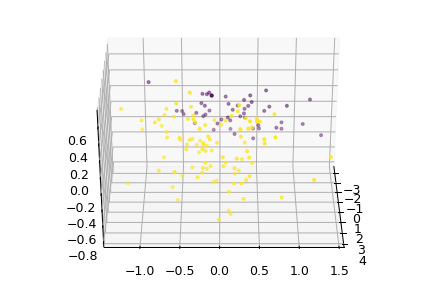

In [6]:
# Importing the clustering dataset
dataset = pd.read_csv('iris.csv')

# Main parameters are the dataset, training size, and problem
find_model(dataset, 1, "clustering", label="species")

In [7]:
# Importing the classification dataset
dataset = pd.read_csv('balance-scale.data')

# Main parameters are the dataset, training size, and problem
find_model(dataset, 0.7, "classification", label="label", datatype="numerical", dim_reduction=True,
           components="auto", contains_negative=True, ensembling=True, priority="accuracy")

Label encoding. . .
Identifying feature columns and label column. . .
Performing dimensionality reduction. . .
Features' shape before reduction is (625, 4)
Using default number of components for principal component analysis. . .
Features' shape after reduction is (625, 2)
Splitting datasets for training and testing. . .
Standardizing values. . .
Ensembing is enabled.
XGBoost classifier score is: 0.7393617021276596 with the following values
for learning rate, g, and number of columns used by each tree: [0.1, 0, 1]
Support vector classifier score is: 0.6861702127659575 with the following values
for g, c, and k: [0.001, 100, 'poly']
K-nearest neighbor classifier score is: 0.6436170212765957 with the k value = 20

With consideration of accuracy as the priority, the best model found for classifying the dataset is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_ste

In [8]:
# Importing the regression problem dataset
dataset = pd.read_csv('boston.csv')

# Main parameters are the dataset, training size, and problem
find_model(dataset, 0.8, "regression", label="medv", dim_reduction=False,
           components="auto", contains_negative=False, ensembling=False)

Identifying feature columns and label column. . .
Splitting datasets for training and testing. . .
Standardizing values. . .
Ensembling is disabled.
Lasso model explained variance score is: 0.7641907554120346 with the values for alpha and max iterations:  [0.1, 100000]
Ridge model explained variance score is: 0.7627421481790335 with the values for alpha and max iterations:  [10, 100000]
Elastic net regression explained variance score is: 0.7627421481790335 with the values
for alpha, max iterations, and l1 ratio:  [10, 100000]
Linear regression explained variance score is: 0.7592556343161431 using
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Support vector regressor explained variance score is: 0.8491405632486696 with the following values
for g, c, and k: [0.001, 1000, 'rbf']

The best model found for the regression problem on the dataset is:
 SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shr